<a href="https://colab.research.google.com/github/shuhbam199/FebGithub/blob/main/movie_recommendation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Problem Statement:
Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

In [1]:
print('hi')

hi


### Data Description:

### Importing required libraries -

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import warnings
import keras
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Embedding, Flatten
from keras.layers import dot
from pylab import rcParams

### Configuring the notebook -

In [ ]:
warnings.simplefilter('ignore')
pd.set_option("display.max_columns", None)
pd.options.display.float_format = '{:.2f}'.format
sns.set_style('white')

### Reading the data files -

In [ ]:
movies = pd.read_fwf('./input/zeemovie/movies.dat', encoding='ISO-8859-1')
ratings = pd.read_fwf('./input/zeemovie/ratings.dat', encoding='ISO-8859-1')
users = pd.read_fwf('./input/zeemovie/users.dat', encoding='ISO-8859-1')

### Data Formatting -

In [ ]:
movies.head()

Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
0  1::Toy Story (1995)::Animation|Children's|Comedy        NaN        NaN
1   2::Jumanji (1995)::Adventure|Children's|Fantasy        NaN        NaN
2        3::Grumpier Old Men (1995)::Comedy|Romance        NaN        NaN
3         4::Waiting to Exhale (1995)::Comedy|Drama        NaN        NaN
4     5::Father of the Bride Part II (1995)::Comedy        NaN        NaN

In [ ]:
movies.drop(columns=['Unnamed: 1', 'Unnamed: 2'], axis=1, inplace=True)

In [ ]:
delimiter = '::'
movies = movies['Movie ID::Title::Genres'].str.split(delimiter, expand=True)
# here expand=True will create a dataframe instead of a series
movies.columns = ['Movie ID', 'Title', 'Genres']

In [ ]:
movies.rename(columns={'Movie ID':'MovieID'}, inplace=True)

In [ ]:
movies.sample(5)

MovieID                                            Title  \
3109    3178                            Hurricane, The (1999)   
605      609  Homeward Bound II: Lost in San Francisco (1996)   
2304    2373                                 Red Sonja (1985)   
3471    3540                           Passion of Mind (1999)   
2695    2764                  Thomas Crown Affair, The (1968)   

                    Genres  
3109                 Drama  
605      Adventure|Childre  
2304      Action|Adventure  
3471      Romance|Thriller  
2695  Crime|Drama|Thriller

In [ ]:
ratings = ratings['UserID::MovieID::Rating::Timestamp'].str.split(delimiter, expand=True)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']

In [ ]:
ratings.head()

UserID MovieID Rating  Timestamp
0      1    1193      5  978300760
1      1     661      3  978302109
2      1     914      3  978301968
3      1    3408      4  978300275
4      1    2355      5  978824291

In [ ]:
users = users['UserID::Gender::Age::Occupation::Zip-code'].str.split(delimiter, expand=True)
users.columns = ['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code']

In [ ]:
users.replace({'Age':{'1':  "Under 18",
                      '18':  "18-24",
                      '25':  "25-34",
                      '35':  "35-44",
                      '45':  "45-49",
                      '50':  "50-55",
                      '56':  "56 Above"}}, inplace=True)

In [ ]:
users.replace({'Occupation':{'0': "other",
                             '1': "academic/educator",
                             '2': "artist",
                             '3': "clerical/admin",
                             '4': "college/grad student",
                             '5': "customer service",
                             '6': "doctor/health care",
                             '7': "executive/managerial",
                             '8': "farmer",
                             '9': "homemaker",
                             '10': "k-12 student",
                             '11': "lawyer",
                             '12': "programmer",
                             '13': "retired",
                             '14': "sales/marketing",
                             '15': "scientist",
                             '16': "self-employed",
                             '17': "technician/engineer",
                             '18': "tradesman/craftsman",
                             '19': "unemployed",
                             '20': "writer"}}, inplace=True)

In [ ]:
users.head()

UserID Gender       Age            Occupation Zip-code
0      1      F  Under 18          k-12 student    48067
1      2      M  56 Above         self-employed    70072
2      3      M     25-34             scientist    55117
3      4      M     45-49  executive/managerial    02460
4      5      M     25-34                writer    55455

### Merging the dataframes -

In [ ]:
df_1 = pd.merge(movies, ratings, how='inner', on='MovieID')
df_1.head()

MovieID             Title                       Genres UserID Rating  \
0       1  Toy Story (1995)  Animation|Children's|Comedy      1      5   
1       1  Toy Story (1995)  Animation|Children's|Comedy      6      4   
2       1  Toy Story (1995)  Animation|Children's|Comedy      8      4   
3       1  Toy Story (1995)  Animation|Children's|Comedy      9      5   
4       1  Toy Story (1995)  Animation|Children's|Comedy     10      5   

   Timestamp  
0  978824268  
1  978237008  
2  978233496  
3  978225952  
4  978226474

In [ ]:
df_2 = pd.merge(df_1, users, how='inner', on='UserID')
df_2.head()

MovieID                                      Title  \
0       1                           Toy Story (1995)   
1      48                          Pocahontas (1995)   
2     150                           Apollo 13 (1995)   
3     260  Star Wars: Episode IV - A New Hope (1977)   
4     527                    Schindler's List (1993)   

                                 Genres UserID Rating  Timestamp Gender  \
0           Animation|Children's|Comedy      1      5  978824268      F   
1  Animation|Children's|Musical|Romance      1      5  978824351      F   
2                                 Drama      1      5  978301777      F   
3               Action|Adventure|Fantas      1      4  978300760      F   
4                             Drama|War      1      5  978824195      F   

        Age    Occupation Zip-code  
0  Under 18  k-12 student    48067  
1  Under 18  k-12 student    48067  
2  Under 18  k-12 student    48067  
3  Under 18  k-12 student    48067  
4  Under 18  k-12 student    48067

In [ ]:
data = df_2.copy(deep=True)
data.sample(10)

MovieID                                            Title  \
45567     1211  Wings of Desire (Der Himmel über Berlin) (1987)   
12842     1247                             Graduate, The (1967)   
67331      852                                   Tin Cup (1996)   
44742     2006                        Mask of Zorro, The (1998)   
17992     2539                              Analyze This (1999)   
107766     318                 Shawshank Redemption, The (1994)   
69972     1881                         Quest for Camelot (1998)   
78231     1834                     Spanish Prisoner, The (1997)   
21678      588                                   Aladdin (1992)   
128073    3717                        Gone in 60 Seconds (2000)   

                                        Genres UserID Rating  Timestamp  \
45567                         Comedy|Drama|Rom    549      5  976118386   
12842                            Drama|Romance    169      5  977196893   
67331                           Comedy|Romance    757      3  975454666   
44742                 Action|Adventure|Romance    543      5  976121494   
17992                                   Comedy    214      4  976900941   
107766                                   Drama     59      3  977934038   
69972   Adventure|Animation|Children's|Fantasy    780      3  975436172   
78231                           Drama|Thriller    127      3  988496394   
21678      Animation|Children's|Comedy|Musical    273      3  976775054   
128073                            Action|Crime    650      4  981996393   

       Gender    Age            Occupation Zip-code  
45567       M  25-34    doctor/health care    53217  
12842       M  25-34  executive/managerial    55439  
67331       M  25-34            programmer    97401  
44742       M  25-34      customer service    55057  
17992       M  18-24                writer    80218  
107766      F  50-55     academic/educator    55413  
69972       M  25-34   technician/engineer    91776  
78231       F  45-49        clerical/admin    01770  
21678       M  18-24  college/grad student    55427  
128073      M  25-34   technician/engineer    49445

### Performing EDA -

Shape of the dataset -

In [ ]:
print("No. of rows: ", data.shape[0])
print("No. of columns: ", data.shape[1])

No. of rows:  132968
No. of columns:  10


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132968 entries, 0 to 132967
Data columns (total 10 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   MovieID     132968 non-null  object
 1   Title       132968 non-null  object
 2   Genres      132493 non-null  object
 3   UserID      132968 non-null  object
 4   Rating      132968 non-null  object
 5   Timestamp   132967 non-null  object
 6   Gender      132968 non-null  object
 7   Age         132968 non-null  object
 8   Occupation  132968 non-null  object
 9   Zip-code    132968 non-null  object
dtypes: object(10)
memory usage: 11.2+ MB


### Feature Engineering -

In [ ]:
data['Rating'].unique()

array(['5', '4', '3', '2', '1', '5:'], dtype=object)

In [ ]:
data.replace({'Rating':{'5:':'5'}}, inplace=True)

In [ ]:
data['Rating'] = data['Rating'].astype('int32')

In [ ]:
data['Datetime'] = pd.to_datetime(data['Timestamp'],
                                  unit='s')

In [ ]:
data['ReleaseYear'] = data['Title'].str.rsplit(' ', 1).str[1] #rsplit will split the string from right side, so rsplit(' ', 1) will split the string from right side and will return the last word
data['ReleaseYear'] = data['ReleaseYear'].str.lstrip("(").str.rstrip(")")

In [ ]:
data['ReleaseYear'].unique()

array(['1995', '1977', '1993', '1992', '1937', '1991', '1996', '1964',
       '1939', '1958', '1950', '1941', '1965', '1982', '1975', '1987',
       '1962', '1989', '1985', '1959', '1997', '1998', '1988', '1942',
       '1947', '1999', '1980', '1983', '1986', '1990', '2000', '1964):',
       '1994', '1978', '1961', '1984', '1972', '1976', '1981', '1973',
       '1974', '1940', 'Bo', '1952', '1954', '1953', '1944', '1968',
       '1957', '1946', '1949', '1951', '1963', '1971', '1979', '1967',
       '1966', '1948', '1933', '1970', '1969', '1930', '1955', '1956', '',
       '1920', '1925', '1938', '195', '1960', '1935', '1932', '1931',
       '1945', '1943', '1981):', '1934', '1936', '1929', 'the', '1926',
       'Arta', 'B', '1927', '19', '1922', 'Polar', '1919', '1921', "d'A",
       '1923', '1989):', '1928'], dtype=object)

In [ ]:
data['ReleaseYear'].replace(['1964):', '1981):', '1989):', '1995):'],
                            ['1964', '1981', '1989', '1995'], inplace=True)

In [ ]:
idx_val = data[(data['ReleaseYear']=='Bo') |
               (data['ReleaseYear']=='195') |
               (data['ReleaseYear']=='') |
               (data['ReleaseYear']=='the') |
               (data['ReleaseYear']=='Arta') |
               (data['ReleaseYear']=='B') |
               (data['ReleaseYear']=='19') |
               (data['ReleaseYear']=='Polar') |
               (data['ReleaseYear']=="d'A") |
               (data['ReleaseYear']=='prendront') |
               (data['ReleaseYear']=='1')].index
data.drop(index=idx_val, inplace=True)

In [ ]:
data['ReleaseYear'] = data['ReleaseYear'].astype('int32')

In [ ]:
data['Title'] = data['Title'].str.rsplit(' ', 1).str[0]

In [ ]:
bins = [1919, 1929, 1939, 1949, 1959, 1969, 1979, 1989, 2000]
labels = ['20s', '30s', '40s', '50s', '60s', '70s', '80s', '90s']
data['ReleaseDec'] = pd.cut(data['ReleaseYear'], bins=bins, labels=labels)

In [ ]:
data.sample(5)

MovieID                        Title                       Genres  \
44230    1148          Wrong Trousers, The             Animation|Comedy   
60273    1676            Starship Troopers  Action|Adventure|Sci-Fi|War   
33349     910             Some Like It Hot                 Comedy|Crime   
724      3252             Scent of a Woman                        Drama   
52030    3398  Muppets Take Manhattan, The            Children's|Comedy   

      UserID  Rating  Timestamp Gender       Age            Occupation  \
44230    541       3  976124683      F     18-24  college/grad student   
60273    710       3  975541809      M     25-34                writer   
33349    412       4  976294038      M     35-44             scientist   
724       10       3  978228727      F     35-44     academic/educator   
52030    629       3  975784137      F  Under 18          k-12 student   

      Zip-code            Datetime  ReleaseYear ReleaseDec  
44230  5849574 2000-12-06 17:44:43         1993        90s  
60273    85207 2000-11-29 23:50:09         1997        90s  
33349    55117 2000-12-08 16:47:18         1959        50s  
724      95370 2000-12-31 02:12:07         1992        90s  
52030    48154 2000-12-02 19:08:57         1984        80s

### Data Cleaning -

Checking for null values -

In [ ]:
data.isna().sum()

MovieID          0
Title            0
Genres         184
UserID           0
Rating           0
Timestamp        1
Gender           0
Age              0
Occupation       0
Zip-code         0
Datetime         1
ReleaseYear      0
ReleaseDec       4
dtype: int64

Checking for duplicate rows -

In [ ]:
duplicate_rows = data[data.duplicated()]
print("No. of duplicate rows: ", duplicate_rows.shape[0])

No. of duplicate rows:  0


### Data Visualization -

#### **Distribution of Movie Ratings -**

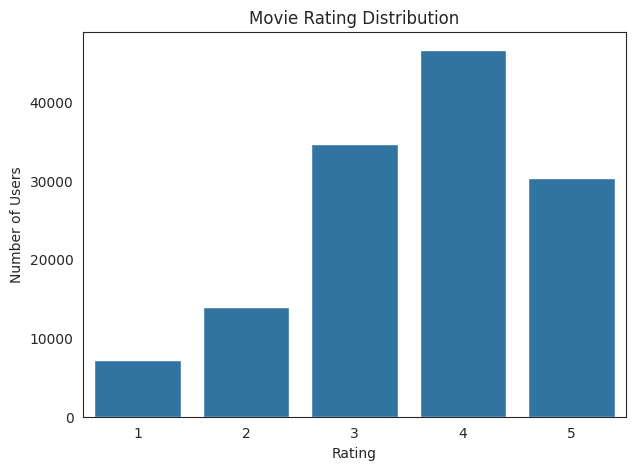

In [ ]:
plt.figure(figsize=(7, 5))
sns.countplot(x='Rating', data=data)
plt.title('Movie Rating Distribution')
plt.xlabel('Rating')
plt.ylabel('Number of Users')
plt.show()

#### **Distribution by Age -**

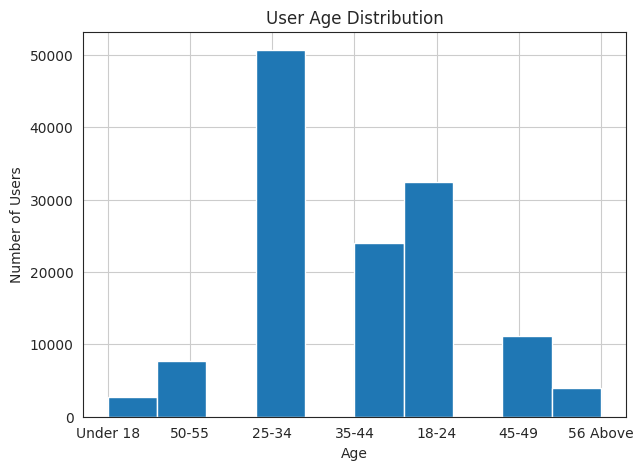

In [ ]:
data['Age'].hist(figsize=(7, 5))
plt.title('User Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Users')
plt.show()

#### **Distribution by Gender -**

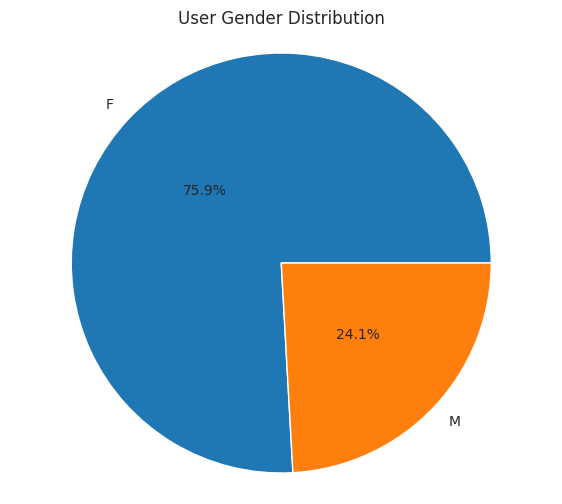

M    100682
F     31995
Name: Gender, dtype: int64

In [ ]:
x = data['Gender'].value_counts().values
plt.figure(figsize=(7, 6))
plt.pie(x, center=(0, 0), radius=1.5, labels=data['Gender'].unique(), autopct='%1.1f%%', pctdistance=0.5)
plt.title('User Gender Distribution')
plt.axis('equal')
plt.show()
data['Gender'].value_counts()

#### **Distribution by Occupation -**

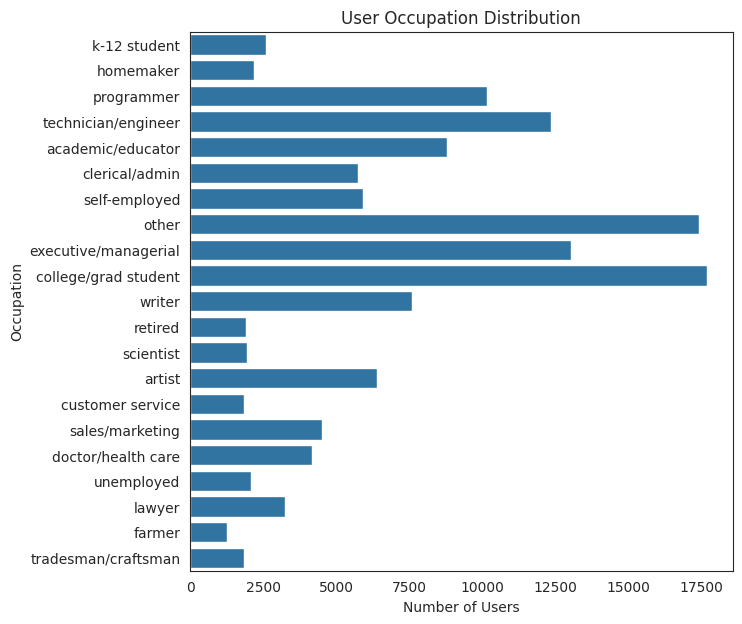

In [ ]:
plt.figure(figsize=(7, 7))
sns.countplot(y='Occupation', data=data)
plt.title('User Occupation Distribution')
plt.xlabel('Number of Users')
plt.ylabel('Occupation')
plt.show()

#### **Distribution by Release Year -**

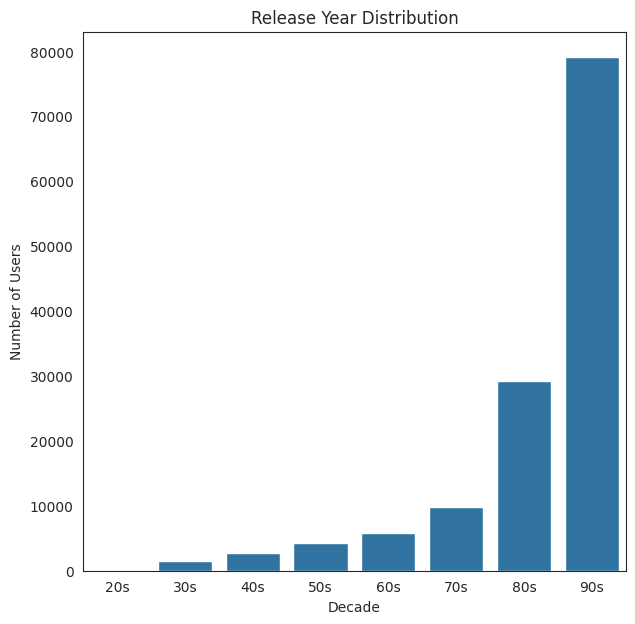

In [ ]:
plt.figure(figsize=(7, 7))
sns.countplot(x='ReleaseDec', data=data)
plt.title('Release Year Distribution')
plt.xlabel('Decade')
plt.ylabel('Number of Users')
plt.show()

### Grouping the data -

#### **Average rating -**

In [ ]:
data.groupby('Title')['Rating'].mean().sort_values(ascending=False).head(10)

Title
Eighth Day, The (Le Huitième jour )      5.00
Hearts and Minds                         5.00
West Beirut (West Beyrouth)              5.00
Lodger, The                              5.00
Autumn Sonata (Höstsonaten )             5.00
Whatever Happened to Aunt Alice?         5.00
Jupiter's Wife                           5.00
Time of the Gypsies (Dom za vesanje)     5.00
Vagabond (Sans toit ni loi)              5.00
Criminal Lovers (Les Amants Criminels)   5.00
Name: Rating, dtype: float64

#### **No. of ratings -**

In [ ]:
data.groupby('Title')['Rating'].count().sort_values(ascending=False).head(10)

Title
American Beauty                                   510
Star Wars: Episode V - The Empire Strikes Back    432
Star Wars: Episode VI - Return of the Jedi        422
Star Wars: Episode IV - A New Hope                417
Jurassic Park                                     410
Matrix, The                                       385
Saving Private Ryan                               376
Terminator 2: Judgment Day                        374
Men in Black                                      365
Raiders of the Lost Ark                           361
Name: Rating, dtype: int64

In [ ]:
df = pd.DataFrame(data.groupby('Title')['Rating'].agg([('Avg rating', 'mean')]))
df['No. of ratings'] = pd.DataFrame(data.groupby('Title')['Rating'].count())

In [ ]:
df.sample(10)

Avg rating  No. of ratings
Title                                                                         
Scream                                                    3.73             108
Bambi                                                     3.84              79
Double Happiness                                          4.00               5
Way of the Gun, The                                       3.19              31
Joe Gould's Secret                                        3.09              11
Until the End of the World (Bis ans Ende der Welt)        3.74              19
Overnight Delivery                                        1.50               2
Fish Called Wanda, A                                      3.89             163
Live Flesh                                                4.50               2
Dancing at Lughnasa                                       3.60               5

### Pivot Table - Creating a User-Item Rating Matrix

It makes it easier to analyze and visualize the relationship b/w average ratings and the number of ratings for each movie.

Creating a pivot table of movie titles and userid -

In [ ]:
mat = pd.pivot_table(data, index='UserID', columns='Title', values='Rating', aggfunc='mean')
mat.head(10)

Title   $1,000,000 Duck  'Night Mother  'Til There Was You  'burbs, The  \
UserID                                                                    
1                   NaN            NaN                 NaN          NaN   
10                  NaN            NaN                 NaN         4.00   
100                 NaN            NaN                 NaN          NaN   
101                 NaN            NaN                 NaN          NaN   
102                 NaN            NaN                 NaN          NaN   
103                 NaN            NaN                 NaN          NaN   
104                 NaN            NaN                 NaN          NaN   
105                 NaN            NaN                 NaN          NaN   
106                 NaN            NaN                 NaN          NaN   
107                 NaN            NaN                 NaN          NaN   

Title   ...And Justice for All  10 Things I Hate About You  101 Dalmatians  \
UserID                                                                       
1                          NaN                         NaN             NaN   
10                         NaN                         NaN             NaN   
100                        NaN                         NaN             NaN   
101                        NaN                         NaN             NaN   
102                        NaN                         NaN             NaN   
103                        NaN                         NaN             NaN   
104                        NaN                         NaN             NaN   
105                        NaN                         NaN             NaN   
106                        NaN                         NaN             NaN   
107                        NaN                         NaN             NaN   

Title   12 Angry Men  13th Warrior, The  187  2 Days in the Valley  20 Dates  \
UserID                                                                         
1                NaN                NaN  NaN                   NaN       NaN   
10              3.00               4.00  NaN                   NaN       NaN   
100              NaN                NaN  NaN                   NaN       NaN   
101              NaN               4.00  NaN                   NaN       NaN   
102              NaN                NaN  NaN                   NaN       NaN   
103              NaN               4.00  NaN                   NaN       NaN   
104              NaN               5.00  NaN                   NaN       NaN   
105              NaN                NaN  NaN                   NaN       NaN   
106              NaN                NaN  NaN                   NaN       NaN   
107             4.00                NaN  NaN                   NaN       NaN   

Title   20,000 Leagues Under the Sea  200 Cigarettes  2001: A Space Odyssey  \
UserID                                                                        
1                                NaN             NaN                    NaN   
10                              4.00             NaN                   3.00   
100                              NaN             NaN                   4.00   
101                              NaN             NaN                    NaN   
102                              NaN             NaN                   1.00   
103                              NaN             NaN                    NaN   
104                              NaN             NaN                    NaN   
105                              NaN             NaN                    NaN   
106                              NaN             NaN                    NaN   
107                              NaN             NaN                   5.00   

Title   2010  24-hour Woman  28 Days  3 Ninjas: High Noon On Mega Mountain  \
UserID                                                                       
1        NaN            NaN      NaN                                   NaN   
10       NaN      

Imputing 'NaN' values with Zero rating -

In [ ]:
mat.fillna(0, inplace=True)

In [ ]:
mat.shape

(858, 3294)

In [ ]:
movie_name = input("Enter a movie name: ")
movie_rating = mat[movie_name]

Enter a movie name: Liar Liar


In [ ]:
similar_movies = mat.corrwith(movie_rating)

In [ ]:
sim_df = pd.DataFrame(similar_movies, columns=['Correlation'])
sim_df.sort_values('Correlation', ascending=False, inplace=True)

In [ ]:
sim_df.iloc[1: , :].head()

Correlation
Title                                 
Mrs. Doubtfire                    0.51
Dumb & Dumber                     0.49
Wedding Singer, The               0.46
Home Alone                        0.45
Robin Hood: Men in Tights         0.44

In [ ]:
item_sim = cosine_similarity(mat.T)
item_sim

array([[1.        , 0.        , 0.        , ..., 0.        , 0.03566315,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.09148553, 0.        ,
        0.02009621],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.09148553, 0.        , ..., 1.        , 0.        ,
        0.18936677],
       [0.03566315, 0.        , 0.        , ..., 0.        , 1.        ,
        0.21794266],
       [0.        , 0.02009621, 0.        , ..., 0.18936677, 0.21794266,
        1.        ]])

#### **Item similarity matrix -**

In [ ]:
item_sim_mat = pd.DataFrame(item_sim, index=mat.columns, columns=mat.columns)
item_sim_mat.head()

Title                   $1,000,000 Duck  'Night Mother  'Til There Was You  \
Title                                                                        
$1,000,000 Duck                    1.00           0.00                0.00   
'Night Mother                      0.00           1.00                0.00   
'Til There Was You                 0.00           0.00                1.00   
'burbs, The                        0.00           0.00                0.09   
...And Justice for All             0.00           0.02                0.00   

Title                   'burbs, The  ...And Justice for All  \
Title                                                         
$1,000,000 Duck                0.00                    0.00   
'Night Mother                  0.00                    0.02   
'Til There Was You             0.09                    0.00   
'burbs, The                    1.00                    0.12   
...And Justice for All         0.12                    1.00   

Title                   10 Things I Hate About You  101 Dalmatians  \
Title                                                                
$1,000,000 Duck                               0.09            0.18   
'Night Mother                                 0.02            0.12   
'Til There Was You                            0.10            0.14   
'burbs, The                                   0.21            0.22   
...And Justice for All                        0.09            0.18   

Title                   12 Angry Men  13th Warrior, The  187  \
Title                                                          
$1,000,000 Duck                 0.03               0.07 0.00   
'Night Mother                   0.00               0.01 0.00   
'Til There Was You              0.16               0.03 0.00   
'burbs, The                     0.20               0.24 0.19   
...And Justice for All          0.26               0.08 0.16   

Title                   2 Days in the Valley  20 Dates  \
Title                                                    
$1,000,000 Duck                         0.00      0.00   
'Night Mother                           0.00      0.00   
'Til There Was You                      0.00      0.18   
'burbs, The                             0.22      0.05   
...And Justice for All                  0.22      0.15   

Title                   20,000 Leagues Under the Sea  200 Cigarettes  \
Title                                                                  
$1,000,000 Duck                                 0.03            0.00   
'Night Mother                                   0.00            0.09   
'Til There Was You                              0.00            0.07   
'burbs, The                                     0.22            0.23   
...And Justice for All                          0.10            0.22   

Title                   2001: A Space Odyssey  2010  24-hour Woman  28 Days  \
Title                                                                         
$1,000,000 Duck                          0.02  0.00           0.00     0.06   
'Night Mother                            0.02  0.06           0.00     0.02   
'Til There Was You                       0.04  0.00           0.27     0.08   
'burbs, The                              0.17  0.17           0.09     0.23   
...And Justice for All                   0.19  0.14           0.00     0.12   

Title                   3 Ninjas: High Noon On Mega Mountain  301, 302  \
Title                                                                    
$1,000,000 Duck                                         0.00      0.00   
'Night Mother                                           0.00      0.00   
'Til There Was You                                      0.00      0.00   
'burbs, The                                             0.03      0.14   
...And Justice for All                                  0.00      0.00   

Title                   39 Steps, The  \
Title                                   
$1,0

In [ ]:
user_sim = cosine_similarity(mat)
user_sim

array([[1.        , 0.25531859, 0.12396703, ..., 0.06699025, 0.12789661,
        0.20832535],
       [0.25531859, 1.        , 0.25964457, ..., 0.20192503, 0.11007634,
        0.20378298],
       [0.12396703, 0.25964457, 1.        , ..., 0.12814012, 0.21196467,
        0.15474294],
       ...,
       [0.06699025, 0.20192503, 0.12814012, ..., 1.        , 0.14595904,
        0.12071075],
       [0.12789661, 0.11007634, 0.21196467, ..., 0.14595904, 1.        ,
        0.1643436 ],
       [0.20832535, 0.20378298, 0.15474294, ..., 0.12071075, 0.1643436 ,
        1.        ]])

#### **User similarity matrix -**

In [ ]:
user_sim_mat = pd.DataFrame(user_sim, index=mat.index, columns=mat.index)
user_sim_mat.head()

UserID    1   10  100  101  102  103  104  105  106  107  108  109   11  110  \
UserID                                                                         
1      1.00 0.26 0.12 0.03 0.12 0.03 0.05 0.10 0.05 0.12 0.05 0.17 0.13 0.04   
10     0.26 1.00 0.26 0.21 0.16 0.15 0.09 0.15 0.17 0.19 0.12 0.34 0.23 0.08   
100    0.12 0.26 1.00 0.35 0.01 0.22 0.03 0.26 0.09 0.17 0.10 0.25 0.12 0.10   
101    0.03 0.21 0.35 1.00 0.09 0.32 0.02 0.24 0.03 0.05 0.15 0.19 0.04 0.10   
102    0.12 0.16 0.01 0.09 1.00 0.04 0.16 0.07 0.07 0.16 0.07 0.12 0.06 0.10   

UserID  111  112  113  114  115  116  117  118  119   12  120  121  122  123  \
UserID                                                                         
1      0.07 0.16 0.08 0.23 0.06 0.06 0.15 0.13 0.20 0.11 0.16 0.10 0.06 0.17   
10     0.18 0.16 0.16 0.27 0.10 0.13 0.38 0.35 0.19 0.09 0.15 0.27 0.18 0.31   
100    0.09 0.02 0.17 0.05 0.10 0.07 0.25 0.32 0.02 0.19 0.27 0.25 0.36 0.23   
101    0.07 0.00 0.18 0.03 0.11 0.09 0.31 0.38 0.06 0.03 0.07 0.22 0.29 0.20   
102    0.05 0.13 0.09 0.07 0.11 0.07 0.09 0.16 0.11 0.09 0.12 0.06 0.07 0.17   

UserID  124  125  126  127  128  129   13  130  131  132  133  134  135  136  \
UserID                                                                         
1      0.06 0.05 0.05 0.13 0.03 0.06 0.12 0.06 0.15 0.09 0.15 0.09 0.14 0.17   
10     0.05 0.15 0.11 0.25 0.11 0.17 0.30 0.22 0.25 0.25 0.18 0.23 0.15 0.32   
100    0.10 0.20 0.11 0.36 0.05 0.26 0.40 0.33 0.19 0.05 0.11 0.24 0.04 0.10   
101    0.04 0.23 0.10 0.28 0.07 0.21 0.34 0.34 0.09 0.04 0.06 0.30 0.05 0.06   
102    0.06 0.10 0.09 0.12 0.04 0.09 0.07 0.09 0.14 0.06 0.11 0.13 0.24 0.15   

UserID  137  138  139   14  140  141  142  143  144  145  146  147  148  149  \
UserID                                                                         
1      0.10 0.06 0.18 0.07 0.05 0.06 0.17 0.11 0.12 0.07 0.22 0.21 0.17 0.12   
10     0.27 0.09 0.37 0.07 0.15 0.08 0.16 0.16 0.10 0.09 0.40 0.27 0.44 0.30   
100    0.24 0.18 0.27 0.01 0.16 0.04 0.17 0.17 0.12 0.00 0.18 0.28 0.28 0.27   
101    0.18 0.08 0.20 0.01 0.08 0.04 0.09 0.13 0.07 0.01 0.14 0.27 0.33 0.22   
102    0.13 0.11 0.10 0.12 0.22 0.05 0.13 0.15 0.10 0.21 0.22 0.13 0.12 0.18   

UserID   15  150  151  152  153  154  155  156  157  158  159   16  160  161  \
UserID                                                                         
1      0.09 0.22 0.14 0.14 0.06 0.05 0.05 0.10 0.13 0.00 0.12 0.04 0.11 0.13   
10     0.22 0.28 0.34 0.15 0.03 0.14 0.21 0.23 0.37 0.07 0.12 0.06 0.14 0.25   
100    0.21 0.17 0.21 0.04 0.03 0.04 0.15 0.07 0.29 0.04 0.07 0.00 0.14 0.17   
101    0.15 0.08 0.16 0.00 0.00 0.04 0.05 0.06 0.23 0.02 0.07 0.04 0.12 0.05   
102    0.12 0.19 0.15 0.05 0.03 0.22 0.07 0.13 0.16 0.19 0.19 0.19 0.08 0.12   

UserID  162  163  164  165  166  167  168  169   17  170  171  172  173  174  \
UserID                                                                         
1      0.16 0.12 0.05 0.08 0.20 0.07 0.14 0.24 0.13 0.13 0.09 0.03 0.13 0.03   
10     0.18 0.23 0.14 0.16 0.35 0.09 0.17 0.44 0.27 0.24 0.08 0.04 0.24 0.20   
100    0.14 0.20 0.03 0.15 0.21 0.05 0.14 0.29 0.20 0.30 0.09 0.02 0.18 0.28   
101    0.23 0.23 0.02 0.09 0.16 0.08 0.10 0.27 0.14 0.20 0.02 0.02 0.11 0.33   
102    0.12 0.16 0.11 0.09 0.16 0.13 0.05 0.20 0.16 0.14 0.05 0.14 0.23 0.10   

UserID  175  176  177  178  179   18  180  181  182  183  184  185  186  187  \
UserID                                                                         
1      0.22 0.07 0.10 0.21 0.07 0.25 0.06 0.15 0.13 0.06 0.30 0.03 0.25 0.10   
10     0.33 0.22 0.27 0.26 0.23 0.36 0.07 0.31 0.22 0.15 0.24 0.15 0.23 0.17   
100    0.19 0.09 0.28 0.14 0.15 0.22 0.07 0.30 0.15 0.06 0.13 0.27 0.18 0.10   
101    0.08 0.09 0.17 0.11 0.15 0.24 0.01 0.22 0.08 0.03 0.11 0.30 0.13 0.04   
102    0.13 0.09 0.08 0.06 0.07 0.13 0.13 0.10 0.09 0.11 0.13 0.02 0.19 0.11   

UserID  188  189   19  190  191  192  193  194  195  196  197  198  199  

### Nearest Neighbors -

In [ ]:
csr_mat = sparse.csr_matrix(mat.T.values)
csr_mat

<3294x858 sparse matrix of type '<class 'numpy.float64'>'
	with 132293 stored elements in Compressed Sparse Row format>

Fitting the model with 'cosine similarity' as the distance metric and 5 (five) as the no. of nearest neighbors.

In [ ]:
knn = NearestNeighbors(n_neighbors=5, metric='cosine', n_jobs=-1)
knn.fit(csr_mat)

NearestNeighbors(metric='cosine', n_jobs=-1)

Let's make recommendations for a movie of the user's choice -

In [ ]:
movie_name = input("Enter a movie name: ")
movie_index = mat.columns.get_loc(movie_name)

Enter a movie name: Liar Liar


In [ ]:
distances, indices = knn.kneighbors(mat[movie_name].values.reshape(1, -1), n_neighbors = 11)

In [ ]:
for i in range(0, len(distances.flatten())):
    if i == 0:
        print('Recommendations for the movie: {0}\n'.format(movie_name))
    else:
        print('{0}: {1}, with distance of {2}'.format(i, mat.columns[indices.flatten()[i]], round(distances.flatten()[i], 3)))

Recommendations for the movie: Liar Liar

1: Mrs. Doubtfire, with distance of 0.429
2: Dumb & Dumber, with distance of 0.462
3: Wedding Singer, The, with distance of 0.469
4: Home Alone, with distance of 0.491
5: Mask, The, with distance of 0.492
6: Austin Powers: International Man of Mystery, with distance of 0.497
7: League of Their Own, A, with distance of 0.503
8: Wayne's World, with distance of 0.503
9: What About Bob?, with distance of 0.507
10: Ace Ventura: Pet Detective, with distance of 0.514


### Matrix Factorization -

Creating embeddings for both users and movies -

In [ ]:
users = data.UserID.unique()
movies = data.MovieID.unique()

userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

The number of dimensions (Latent Factors) in the embeddings is a hyperparameter to deal with in this implementation of Collaborative Filtering.

In [ ]:
data['UserID'] = data['UserID'].apply(lambda x: userid2idx[x])
data['MovieID'] = data['MovieID'].apply(lambda x: movieid2idx[x])
split = np.random.rand(len(data)) < 0.8
train = data[split]
valid = data[~split]
print(train.shape, valid.shape)

(106322, 13) (26355, 13)


In [ ]:
n_movies = len(data['MovieID'].unique())
n_users = len(data['UserID'].unique())
n_latent_factors = 64  # Hyperparamter

In [ ]:
user_input = Input(shape=(1, ), name='user_input', dtype='int64')

In [ ]:
user_embedding = Embedding(n_users, n_latent_factors, name='user_embedding')(user_input)

In [ ]:
user_vec = Flatten(name='FlattenUsers')(user_embedding)

In [ ]:
movie_input = Input(shape=(1, ), name='movie_input', dtype='int64')
movie_embedding = Embedding(n_movies, n_latent_factors, name='movie_embedding')(movie_input)
movie_vec = Flatten(name='FlattenMovies')(movie_embedding)

In [ ]:
sim = dot([user_vec, movie_vec], name='Simalarity-Dot-Product', axes=1)
model = keras.models.Model([user_input, movie_input], sim)

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='mse')

Let's see the model's summary -

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 movie_input (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 64)                54912     ['user_input[0][0]']          
                                                                                                  
 movie_embedding (Embedding  (None, 1, 64)                213376    ['movie_input[0][0]']         
 )                                                                                            

### Model Training -

In [ ]:
model_hist = model.fit([train.UserID, train.MovieID], train.Rating,
                       batch_size=128, epochs=20,
                       validation_data = ([valid.UserID, valid.MovieID], valid.Rating),
                       verbose=1)

Epoch 1/20
831/831 [==============================] - 14s 14ms/step - loss: 10.7874 - val_loss: 2.9350
Epoch 2/20
831/831 [==============================] - 3s 4ms/step - loss: 1.5875 - val_loss: 1.1021
Epoch 3/20
831/831 [==============================] - 3s 4ms/step - loss: 0.9572 - val_loss: 0.9357
Epoch 4/20
831/831 [==============================] - 4s 4ms/step - loss: 0.8480 - val_loss: 0.8915
Epoch 5/20
831/831 [==============================] - 3s 4ms/step - loss: 0.7925 - val_loss: 0.8686
Epoch 6/20
831/831 [==============================] - 3s 3ms/step - loss: 0.7490 - val_loss: 0.8558
Epoch 7/20
831/831 [==============================] - 3s 4ms/step - loss: 0.7099 - val_loss: 0.8476
Epoch 8/20
831/831 [==============================] - 3s 3ms/step - loss: 0.6694 - val_loss: 0.8463
Epoch 9/20
831/831 [==============================] - 4s 5ms/step - loss: 0.6292 - val_loss: 0.8467
Epoch 10/20
831/831 [==============================] - 4s 4ms/step - loss: 0.5863 - val_loss: 0.8

### Model Evaluation -

In [ ]:
y_pred = model.predict([valid.UserID, valid.MovieID], verbose=0)
y_pred_class = np.argmax(y_pred, axis=-1)

Calculating the RMSE -

In [ ]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(valid.Rating, y_pred, squared=False)
print('Root Mean Squared Error: {:.3f}'.format(rmse))

Root Mean Squared Error: 0.990


Calculating the MAPE -

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
mape =  mean_absolute_percentage_error(valid.Rating, y_pred)
print('Mean Absolute Percentage Error: {:.3f}'.format(mape))

Mean Absolute Percentage Error: 0.284


Plotting the Model Loss -

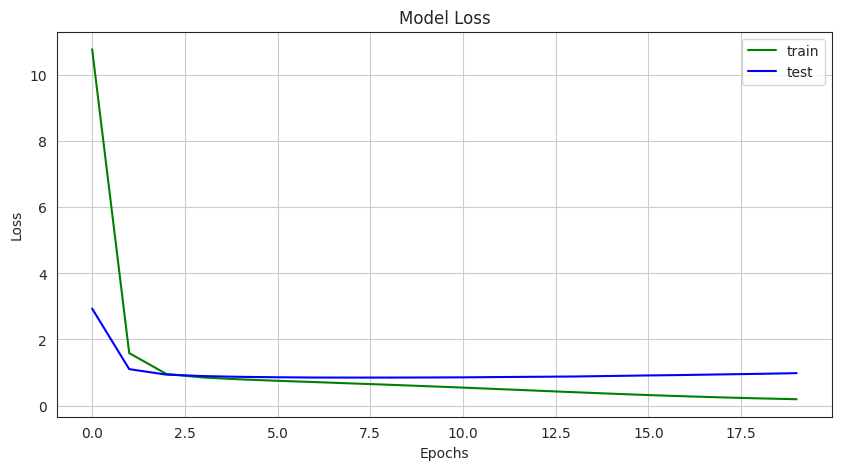

In [ ]:
rcParams['figure.figsize'] = 10, 5
plt.plot(model_hist.history['loss'] , 'g')
plt.plot(model_hist.history['val_loss'] , 'b')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc='upper right')
plt.grid(True)
plt.show()

#### **User-based approach: (Optional)**

given our user 4 (four) movie names and asked them to rate these movies according to their liking.

In [ ]:
mov_name = ['Mrs. Doubtfire', 'Dumb & Dumber', 'Ace Ventura: Pet Detective', 'Home Alone']

In [ ]:
mov_id = []
for mov in mov_name:
    id = data[data['Title'] == mov]['MovieID'].iloc[0]
    mov_id.append(id)

In [ ]:
mov_rating = list(map(int, input("Rate these movies respectively: ").split()))

Rate these movies respectively: 3 4 5 5


Creating a dataframe for a new user's choices.

In [ ]:
user_choices = pd.DataFrame({'MovieID': mov_id,
                            'Title': mov_name,
                            'Rating': mov_rating})
user_choices.sort_values(by='MovieID')

MovieID                       Title  Rating
2      316  Ace Ventura: Pet Detective       5
3      328                  Home Alone       5
1      978               Dumb & Dumber       4
0     1009              Mrs. Doubtfire       3

Users who have watched the same movies as the new users.

In [ ]:
other_users = data[data['MovieID'].isin(user_choices['MovieID'].values)]
other_users = other_users[['UserID', 'MovieID', 'Rating']]
other_users['UserID'].nunique()

206

Sorting old users by the count of most movies in common with the new user.

In [ ]:
common_movies = other_users.groupby(['UserID'])
common_movies = sorted(common_movies, key=lambda x: len(x[1]), reverse=True)
common_movies[0]

(9,
       UserID  MovieID  Rating
 1687       9      978       1
 1705       9      316       1
 1738       9     1009       3
 1749       9      328       2)

In [ ]:
top_users = common_movies[:100]

Calculating a Similarity Score for each user using Pearson Correlation function -

In [ ]:
pearson_corr = {}

for user_id, movies in top_users:
    movies = movies.sort_values(by='MovieID')
    movie_list = movies['MovieID'].values

    new_user_ratings = user_choices[user_choices['MovieID'].isin(movie_list)]['Rating'].values
    user_ratings = movies[movies['MovieID'].isin(movie_list)]['Rating'].values

    corr = pearsonr(new_user_ratings, user_ratings)
    pearson_corr[user_id] = corr[0]

Get top 10 users with the highest similarity indices.

In [ ]:
pearson_df = pd.DataFrame(columns=['UserID', 'Similarity Index'], data=pearson_corr.items())
pearson_df = pearson_df.sort_values(by='Similarity Index', ascending=False)[:10]
pearson_df

UserID  Similarity Index
70      39              1.00
72      48              1.00
80     115              1.00
84     177              1.00
95     286              1.00
96     336              1.00
47     231              1.00
57     324              0.94
2       72              0.87
27     415              0.87

Get all movies for these users and add weighted movie ratings.

In [ ]:
users_rating = pearson_df.merge(data, on='UserID', how='inner')
users_rating['Weighted Rating'] = users_rating['Rating'] * users_rating['Similarity Index']
users_rating = users_rating[['UserID', 'MovieID', 'Rating', 'Similarity Index', 'Weighted Rating']]
users_rating

UserID  MovieID  Rating  Similarity Index  Weighted Rating
0         39        0       3              1.00             3.00
1         39      844       5              1.00             5.00
2         39      845       4              1.00             4.00
3         39      115       4              1.00             4.00
4         39      116       4              1.00             4.00
...      ...      ...     ...               ...              ...
4514     415     1144       2              0.87             1.74
4515     415      588       5              0.87             4.35
4516     415      589       4              0.87             3.48
4517     415     1655       2              0.87             1.74
4518     415     1830       4              0.87             3.48

[4519 rows x 5 columns]

Calculating average recommendation score and selecting items with the highest score.

In [ ]:
# Calculate sum of similarity index and weighted rating for each movie
grouped_ratings = users_rating.groupby('MovieID').sum()[['Similarity Index', 'Weighted Rating']]

recommend_movies = pd.DataFrame()

# Add average recommendation score.
# We're calculating average recommendation score by dividing the Weighted Rating by the Similarity Index.
recommend_movies['avg_reccomend_score'] = grouped_ratings['Weighted Rating']/grouped_ratings['Similarity Index']
recommend_movies['MovieID'] = grouped_ratings.index
recommend_movies = recommend_movies.reset_index(drop=True)

# Select movies with the highest score i.e. 5
recommend_movies = recommend_movies[(recommend_movies['avg_reccomend_score'] == 5)]

Let's see 10 movies recommended based on the ratings given by old users who are similar to the new user.

In [ ]:
recommendations = data[data['MovieID'].isin(recommend_movies['MovieID'])][['MovieID', 'Title']].sample(10)
recommendations

MovieID                                    Title
50558       334  Mystery Science Theater 3000: The Movie
129478      196      Life Is Beautiful (La Vita è bella)
114834       24                    To Kill a Mockingbird
54420       577                         Romeo and Juliet
102160     1915                             Mission, The
73635       819                    Bringing Out the Dead
128282      217                        Anna and the King
19255       453                            Soylent Green
62070      1598                              Wonder Boys
115533     1025                            She's the One

/var/folders/p6/6_nprx9x22s4njm57gzb34l40000gp/T/ipykernel_66147/323488502.py:15: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(red_values, normalize=True).sort_index().plot(kind="bar", grid=True)
/var/folders/p6/6_nprx9x22s4njm57gzb34l40000gp/T/ipykernel_66147/323488502.py:15: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  pd.value_counts(red_values, normalize=True).sort_index().plot(kind="bar", grid=True)


<Axes: >

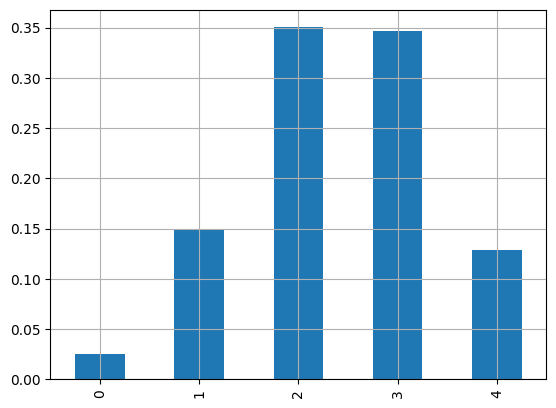

In [ ]:
import numpy as np
import pandas as pd

red_values=[]

for person in range(10000):
    rolls=np.random.choice(["R","R","R","B","B"],size=4)
    num_red=np.count_nonzero(rolls=="R")
    red_values.append(num_red)


# pd.value_counts(red_values).plot(kind="bar", grid=True) #plot this as not as count but percentage


pd.value_counts(red_values, normalize=True).sort_index().plot(kind="bar", grid=True)